## Baseline models

In [30]:
import dataloader
import DataDLC
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import importlib
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

import joblib
from sklearn.metrics import confusion_matrix
import seaborn as sns
import cv2

In [31]:
importlib.reload(dataloader)
importlib.reload(DataDLC)

<module 'DataDLC' from 'c:\\Users\\jalvarez\\Documents\\Code\\GitHubCOde\\Behavioral_Tagging_of_Mice_in_multiple_Mice_dataset_using_Deep_Learning\\src\\DataDLC.py'>

**Load DMD_null male dataset**

In [32]:
# Deactivate warnings
import warnings
warnings.filterwarnings('ignore')

data_loader = dataloader.DLCDataLoader(r'c:\Users\jalvarez\Documents\Data\LargeDataset', build_graph=False)

['DMD_fem_Test_10DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5', 'DMD_fem_Test_11DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5', 'DMD_fem_Test_12DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5', 'DMD_fem_Test_13DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5', 'DMD_fem_Test_14DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5', 'DMD_fem_Test_15DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5', 'DMD_fem_Test_16DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5', 'DMD_fem_Test_17DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5', 'DMD_fem_Test_18DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5', 'DMD_fem_Test_19DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5', 'DMD_fem_Test_1DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5', 'DMD_fem_Test_20DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5', 'DMD_fem_Test_21

In [6]:
data_loader[0][0].values.shape

(2631, 108)

#### Split the trainning and test dataset

In [7]:
dataset = data_loader.data_list


In [8]:
# behaviour names
beh_names = dataset[0][1].columns
beh_names

Index(['General_Contacts', 'Sniffing_R', 'Sniffing_head_R', 'Sniffing_other_R',
       'Sniffing_anal_R', 'Poursuit_R', 'Dominance_R', 'Rearing_R',
       'Grooming_R', 'Sniffing_V', 'Sniffing_head_V', 'Sniffing_other_V',
       'Sniffing_anal_V', 'Poursuit_V', 'Dominance_V', 'Rearing_V',
       'Grooming_V'],
      dtype='object')

In [9]:

y = []
coords_dmd_null = []
behaviour = []

for i in tqdm.tqdm(range(len(dataset))):

    ### Prepare a dataset wich is simply all the points concatenated
    n_frames, n_features_coords = dataset[i][0].values.shape
    n_bp_tot = n_features_coords // 3 # 3 coordinates per body part (body parts of both individuals)
    coords = dataset[i][0].values.reshape(n_frames*n_bp_tot, 3) # Only to treat NANs

    has_nan = np.isnan(coords).any(axis=1)
    coords[has_nan, :] = [0, 0, 0]
    coords = coords.reshape(n_frames, n_features_coords) # Back to the original shape

    if coords.shape[0] != dataset[i][1].shape[0]:
        print("Warrning: ", i, " ", coords.shape[0], " ", dataset[i][1].shape[0])
    coords_dmd_null.append(coords)
    behaviour.append(dataset[i][1].to_numpy())

100%|██████████| 118/118 [00:00<00:00, 207.51it/s]


In [10]:
y = np.concatenate(behaviour)
X = np.concatenate(coords_dmd_null)

In [11]:
print(X.shape)
print(y.shape)

(310549, 108)
(310549, 17)


In [12]:
# Split the data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [13]:
bodyparts = dataset[0][0].columns.levels[1]
bodyparts

Index(['Center', 'Center_head', 'Left_bhip', 'Left_ear', 'Left_fhip',
       'Left_mid', 'Nose', 'Right_bhip', 'Right_ear', 'Right_fhip',
       'Right_mid', 'Spine_1', 'Spine_1-center', 'Spine_2', 'Spine_2-base',
       'Spine_center-2', 'Tail_1', 'Tail_2', 'Tail_3', 'Tail_4', 'Tail_base',
       'Tail_tip', 'Center of mass'],
      dtype='object', name='bodyparts')

In [14]:
doble_bp = np.concatenate([bodyparts, bodyparts])
doble_bp

array(['Center', 'Center_head', 'Left_bhip', 'Left_ear', 'Left_fhip',
       'Left_mid', 'Nose', 'Right_bhip', 'Right_ear', 'Right_fhip',
       'Right_mid', 'Spine_1', 'Spine_1-center', 'Spine_2',
       'Spine_2-base', 'Spine_center-2', 'Tail_1', 'Tail_2', 'Tail_3',
       'Tail_4', 'Tail_base', 'Tail_tip', 'Center of mass', 'Center',
       'Center_head', 'Left_bhip', 'Left_ear', 'Left_fhip', 'Left_mid',
       'Nose', 'Right_bhip', 'Right_ear', 'Right_fhip', 'Right_mid',
       'Spine_1', 'Spine_1-center', 'Spine_2', 'Spine_2-base',
       'Spine_center-2', 'Tail_1', 'Tail_2', 'Tail_3', 'Tail_4',
       'Tail_base', 'Tail_tip', 'Center of mass'], dtype=object)

Checking outliers


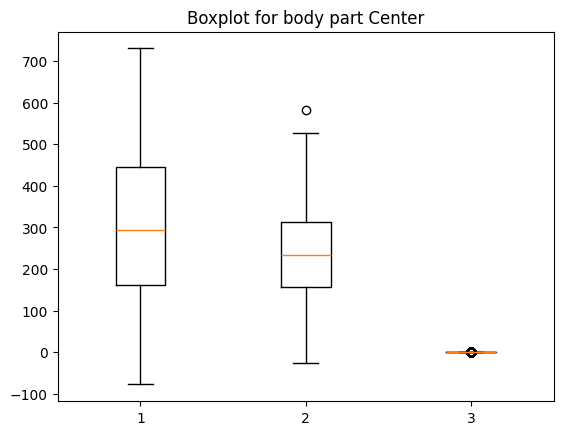

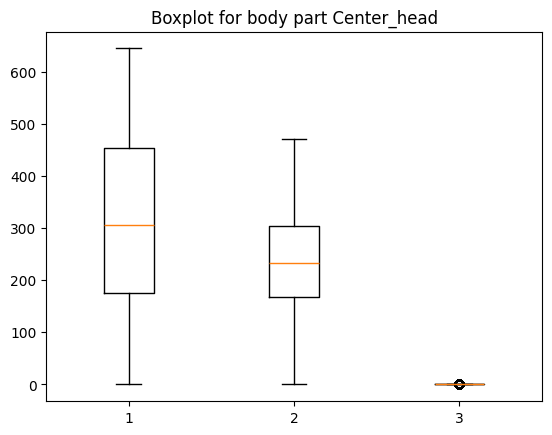

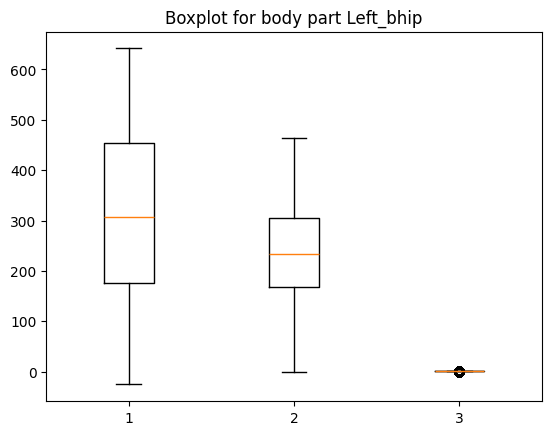

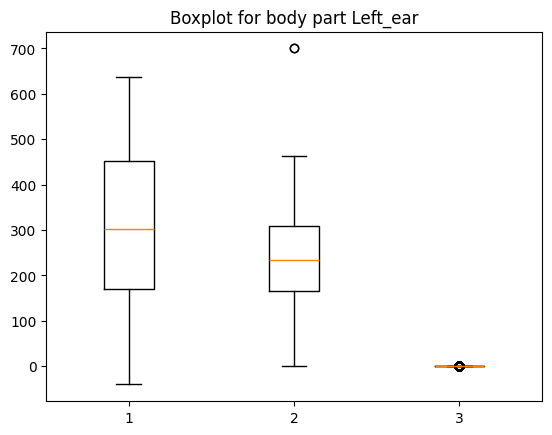

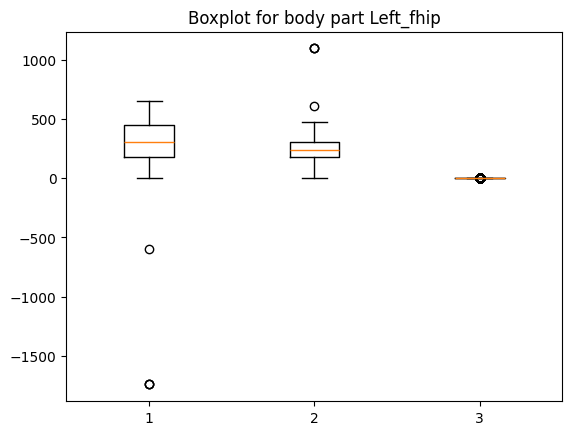

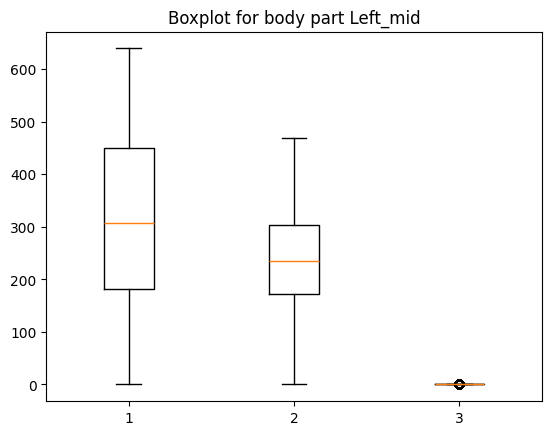

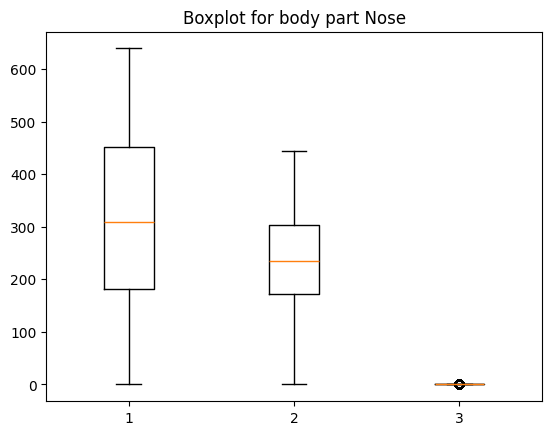

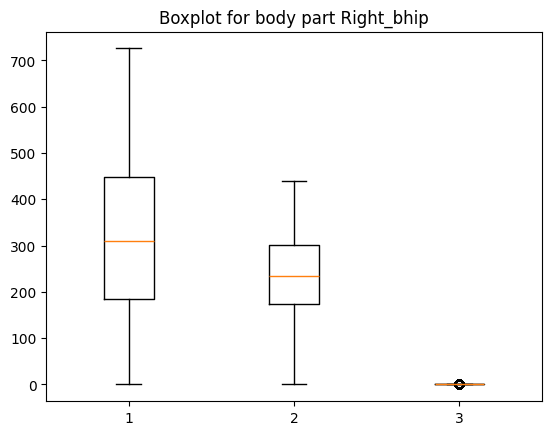

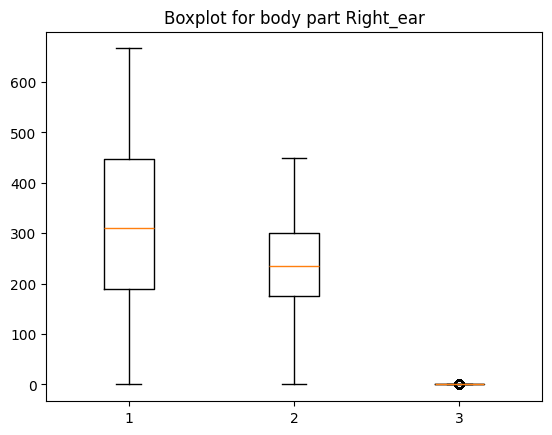

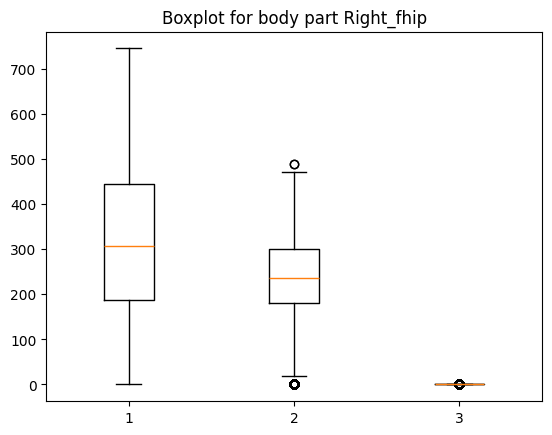

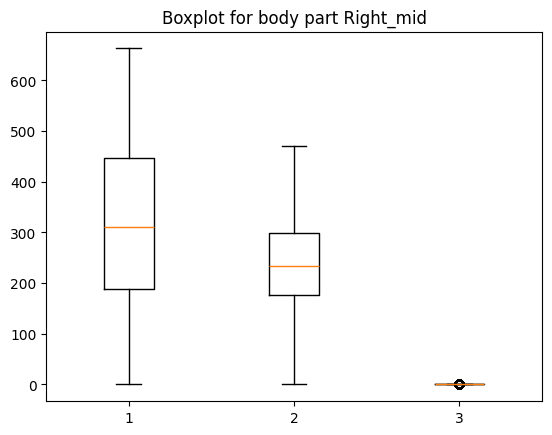

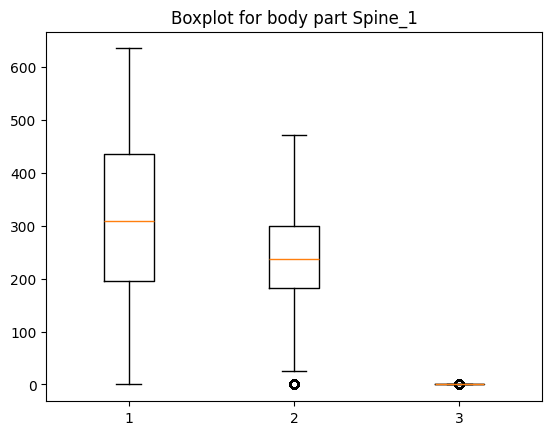

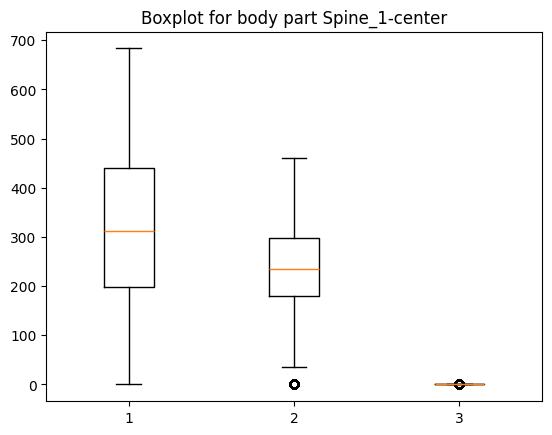

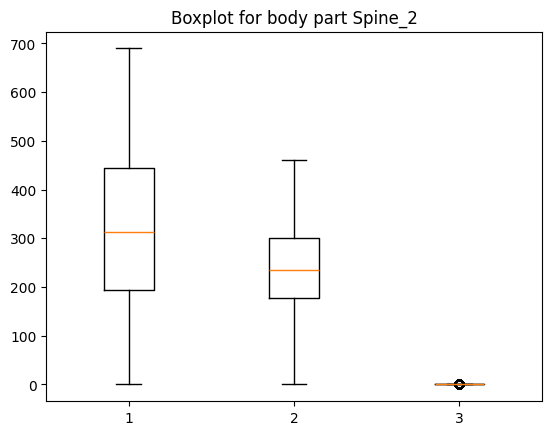

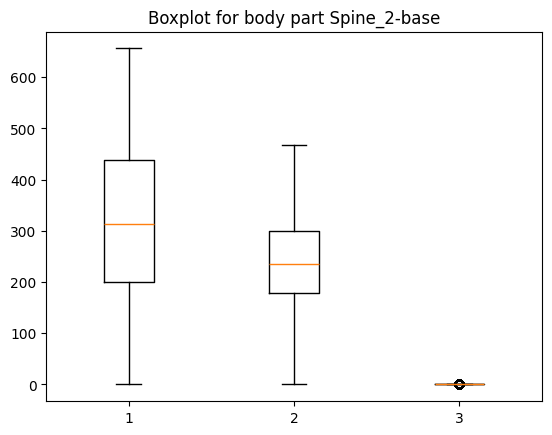

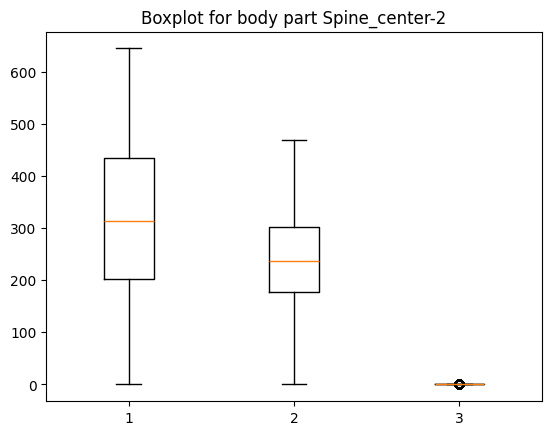

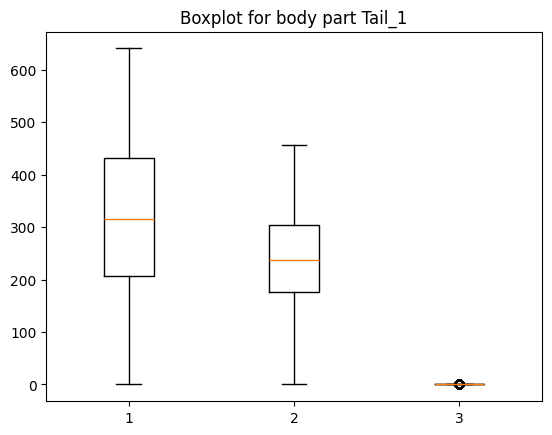

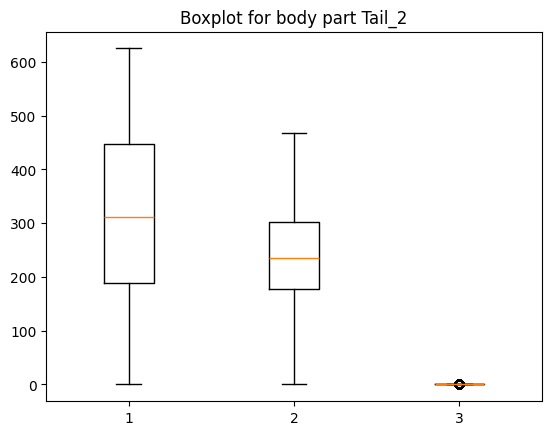

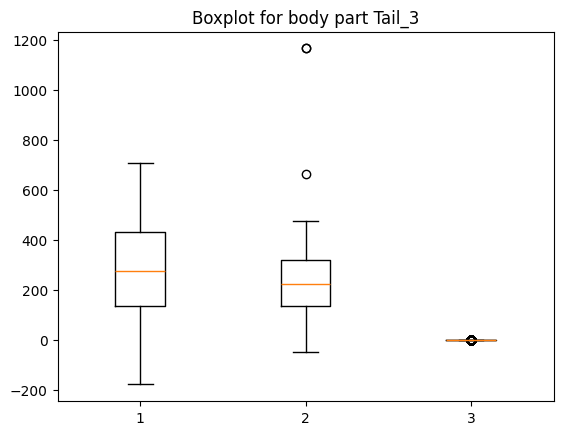

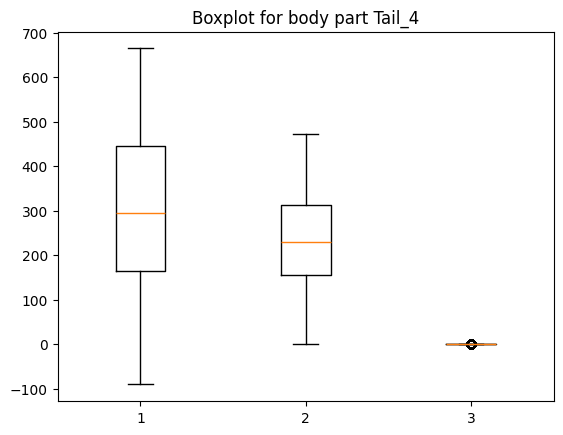

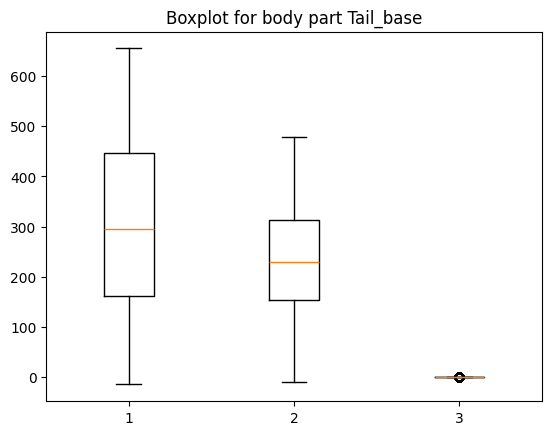

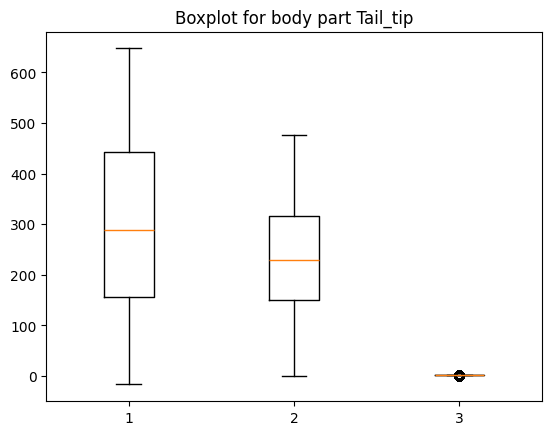

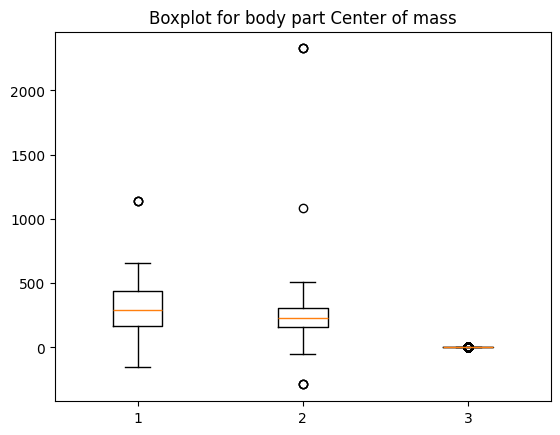

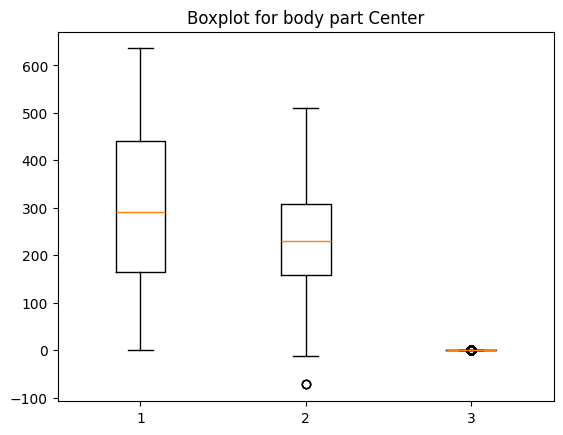

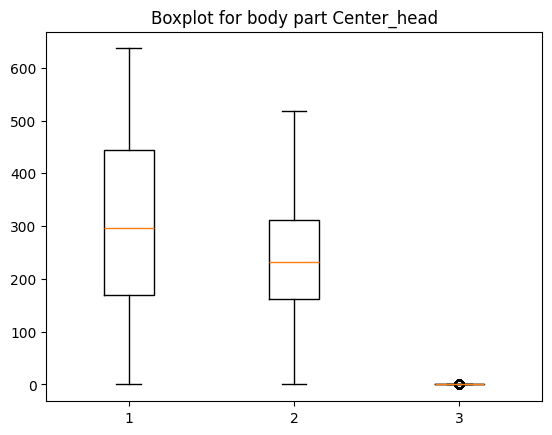

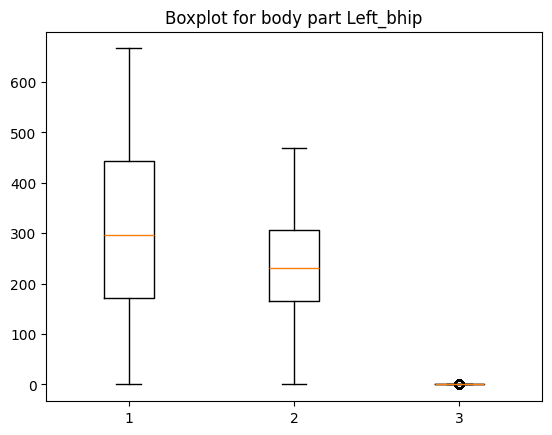

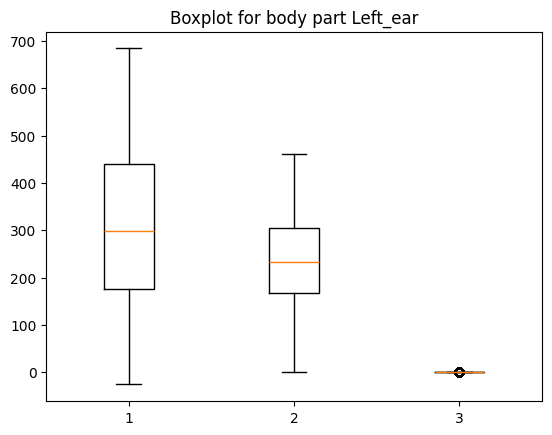

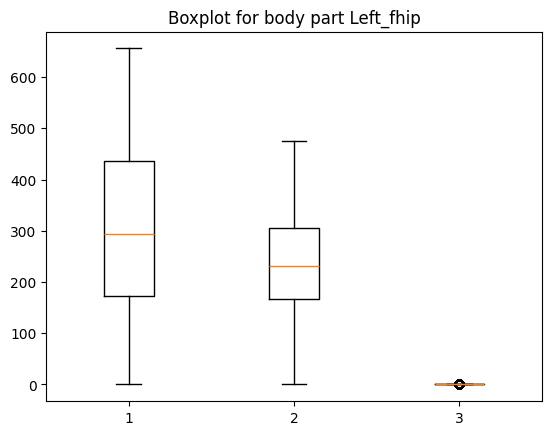

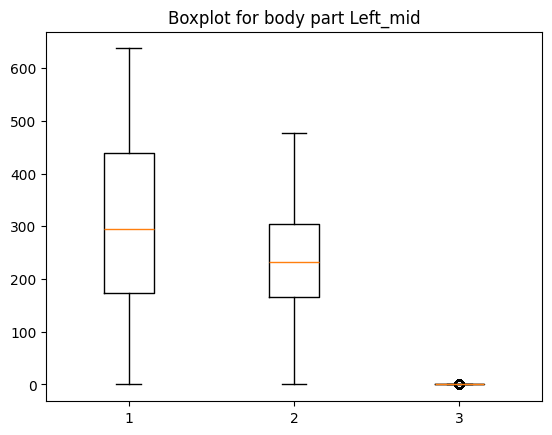

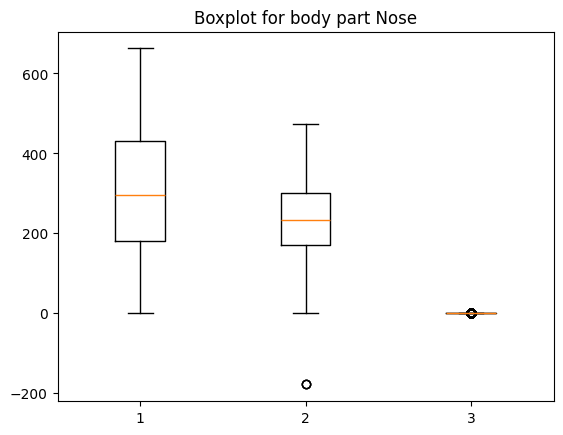

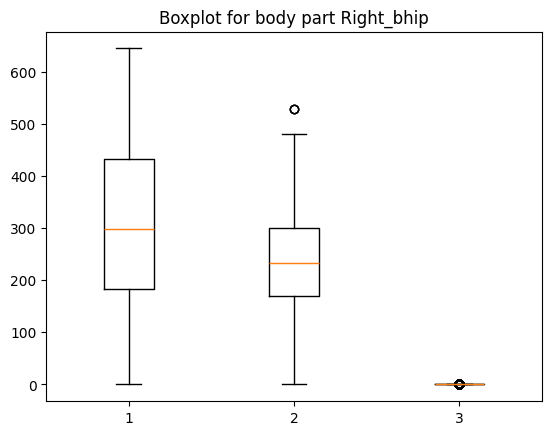

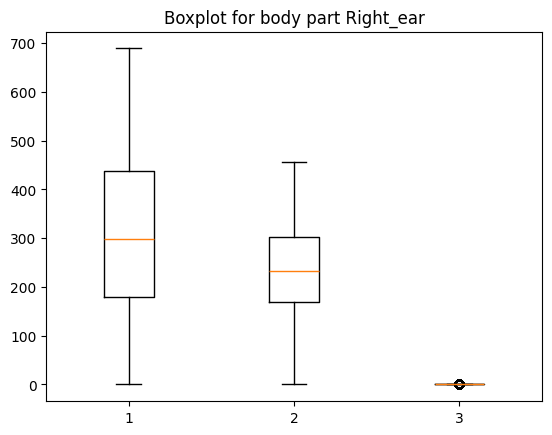

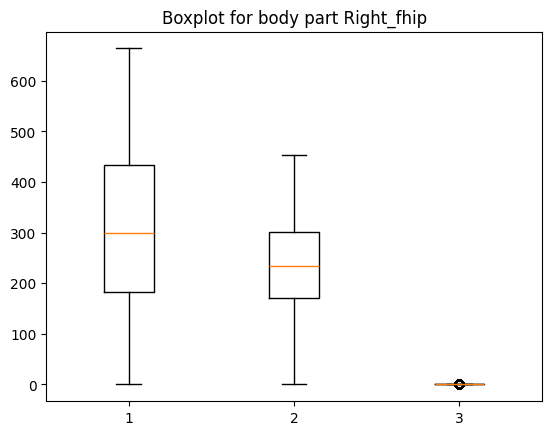

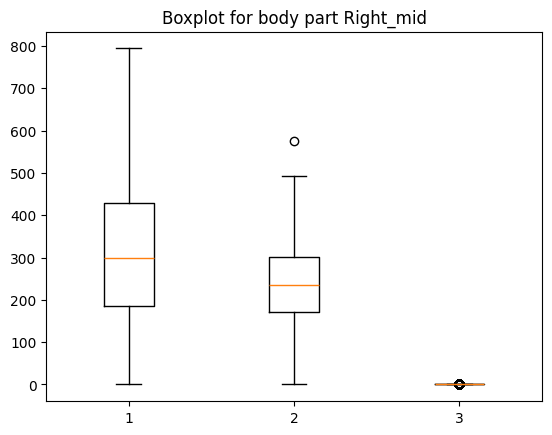

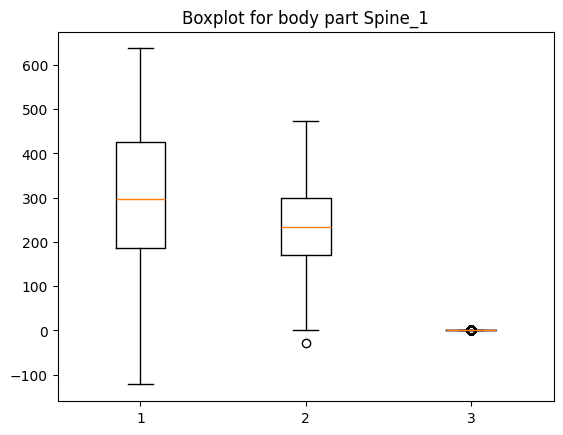

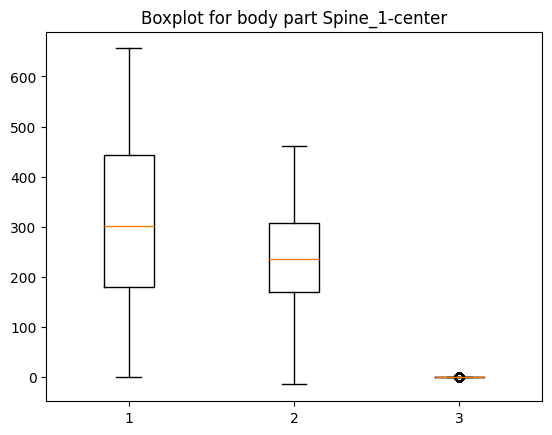

In [15]:
# Check outliers
print("Checking outliers")
# Boxplot
for i in range(X_train.shape[1]//3):
    plt.boxplot(X_train[:, i*3:(i+1)*3])
    plt.title('Boxplot for body part ' + doble_bp[i])
    plt.show()

**Let's check the size of the videos to see the bounderies, the trainning videos were cropped to (640,480)**

In [16]:
# Load a video
path = r'c:\Users\jalvarez\Documents\Data\DLC_analyzedvid\MDX5CV_wo_tail\MDX5CV male\MDXCV_mal_Test_1.mp4'

# Load the video
cap = cv2.VideoCapture(path)
ret, frame = cap.read()
cap.release()

# Get the size of the video
height, width, _ = frame.shape

print("Video size: ", width, height)

# Close everything
cv2.destroyAllWindows()
cv2.waitKey(1)

Video size:  640 480


-1

In [17]:
# Introduce boundaries in features
x_lim = [0, width]
y_lim = [0, height]

# Cast outliers to the limits
print( ' before clipping: ', X_train[:, 0::3].max(), X_train[:, 0::3].min())
print( ' before clipping: ', X_train[:, 1::3].max(), X_train[:, 1::3].min())
X_train[:, 0::3] = np.clip(X_train[:, 0::3], x_lim[0], x_lim[1])
X_train[:, 1::3] = np.clip(X_train[:, 1::3], y_lim[0], y_lim[1])
X_test[:, 0::3] = np.clip(X_test[:, 0::3], x_lim[0], x_lim[1])
X_test[:, 1::3] = np.clip(X_test[:, 1::3], y_lim[0], y_lim[1])
print( ' after clipping: ', X_train[:, 0::3].max(), X_train[:, 0::3].min())
print( ' after clipping: ', X_train[:, 1::3].max(), X_train[:, 1::3].min())


 before clipping:  1139.667565412415 -1742.2799189725774
 before clipping:  2325.901155355654 -288.10640923857045
 after clipping:  640.0 0.0
 after clipping:  480.0 0.0


In [18]:
# Scale the data 
X_train[:, 0::3] = (X_train[:, 0::3] - x_lim[0]) / (x_lim[1] - x_lim[0])
X_train[:, 1::3] = (X_train[:, 1::3] - y_lim[0]) / (y_lim[1] - y_lim[0])
X_test[:, 0::3] = (X_test[:, 0::3] - x_lim[0]) / (x_lim[1] - x_lim[0])
X_test[:, 1::3] = (X_test[:, 1::3] - y_lim[0]) / (y_lim[1] - y_lim[0])


# Scale the test

In [19]:
print( ' after clipping: ', X_train[:, 0::3].max(), X_train[:, 0::3].min())
print( ' after clipping: ', X_train[:, 1::3].max(), X_train[:, 1::3].min())

 after clipping:  1.0 0.0
 after clipping:  1.0 0.0


In [20]:
print(X_train.shape)
print(X_test.shape)


(248439, 108)
(62110, 108)


---

In [21]:
beh_names[0]

'General_Contacts'

In [22]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### General contact

In [21]:
y_gencont_train = y_train[:, 0]
y_gencont_test = y_test[:, 0]

In [ ]:
# class balance
plt.hist(y_gencont_train)
plt.show()

print()

In [ ]:
# Load baseline model
model = joblib.load(r'C:\Users\jalvarez\Documents\Code\GitHubCOde\Behavioral_Tagging_of_Mice_in_multiple_Mice_dataset_using_Deep_Learning\src\baseline_models\model_gencont.pkl')

# Print the model and number of parameters
print(model)
total_params = 0
for layer in model.coefs_:
    total_params += layer.size
print("Total number of parameters: ", total_params)

In [24]:
# Create the model
model = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, verbose=True)

In [ ]:
# 5 train to see variance
n_train = 5
accs = []
models = []
for i in range(n_train):
    print("Train ", i)
    model = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, verbose=True, random_state=np.random.randint(0, 1000))
    model.fit(X_train, y_gencont_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_gencont_test, y_pred)
    accs.append(acc)
    models.append(model)
    print("Accuracy: ", acc)


In [ ]:
# accuracy
print("Mean accuracy: ", np.mean(accs))
print("Std accuracy: ", np.std(accs))
print(" variance accuracy: ", np.var(accs))

print("The accuracy is:", np.mean(accs), " +/- ", np.std(accs))

In [ ]:
# Best model
model = models[np.argmax(accs)]
y_pred = model.predict(X_test)
acc = accuracy_score(y_gencont_test, y_pred)
print("Accuracy: ", acc)

# Confusion matrix
cm = confusion_matrix(y_gencont_test, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plt.title('Confusion matrix of the best model for general contact')
sns.heatmap(cm, annot=True, xticklabels=['Not Contact', 'Contact'], yticklabels=['Not Contact', 'Contact'], cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



In [ ]:
model.fit(X_train, y_gencont_train)

In [ ]:
y_pred = model.predict(X_test)

accuracy_score(y_gencont_test, y_pred)

In [ ]:
# Confusion matrix


conf_matrix = confusion_matrix(y_gencont_test, y_pred)
conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_matrix, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
# save model

joblib.dump(model, 'baseline_models/new_dataset/model_gencont.pkl')

---

In [ ]:
beh_names[1]

## Sniff resident

In [20]:
y_sniffR_train = y_train[:, 1]
y_sniffR_test = y_test[:, 1]


In [ ]:
# Class Balance
plt.hist(y_sniffR_train)
plt.title('Train class balance')
plt.show()


In [24]:
model = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, verbose=True)

In [ ]:
# number of parameters
total_params = 0
for layer in model.coefs_:
    total_params += layer.size
print("Total number of parameters: ", total_params)


In [ ]:
# 5 train to see variance
n_train = 5
accs = []
models = []
for i in range(n_train):
    print("Train ", i)
    model = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, verbose=True)
    model.fit(X_train, y_sniffR_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_sniffR_test, y_pred)
    accs.append(acc)
    models.append(model)
    print("Accuracy: ", acc)


In [ ]:
# accuracy
print("Mean accuracy: ", np.mean(accs))
print("Std accuracy: ", np.std(accs))
print(" variance accuracy: ", np.var(accs))

print("The accuracy is:", np.mean(accs), " +/- ", np.std(accs))

In [ ]:
# Best model
model = models[np.argmax(accs)]


In [23]:
# load model
model = joblib.load('baseline_models/new_dataset/model_sniffR.pkl')

In [ ]:

y_pred = model.predict(X_test)
acc = accuracy_score(y_sniffR_test, y_pred)
print("Accuracy: ", acc)

# Confusion matrix
cm = confusion_matrix(y_sniffR_test, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plt.title('Confusion matrix of the best model for Sniffing')
sns.heatmap(cm, annot=True, xticklabels=['No Sniffing', 'Sniffing'], yticklabels=['No Sniffing', 'Sniffing'], cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
# Save the model
joblib.dump(model, 'baseline_models/new_dataset/model_sniffR.pkl')

In [ ]:
train_errors = model.loss_curve_
plt.plot(train_errors)
plt.xlabel('Iteration')
plt.ylabel('Training Error')
plt.show()


In [ ]:
# Save the model
joblib.dump(model, 'baseline_models/new_dataset/model_sniffR.pkl')

---

In [ ]:
beh_names[2]

### Sniffing_head_R

In [26]:
y_Shead_train = y_train[:, 2]
y_Shead_test = y_test[:, 2]

In [ ]:
#Class balance
plt.hist(y_Shead_train)
plt.title('Train class balance')
plt.show()

print("Train active: ", int(np.sum(y_Shead_train)))
print("Train inactive: ", np.sum(y_Shead_train == 0))
print("Percentage active: ", np.sum(y_Shead_train)*100 / len(y_Shead_train), "%")


In [38]:
# Downsample the inactive class
idx = np.where(y_Shead_train == 0)[0]
idx = np.random.choice(idx, np.sum(y_Shead_train == 1), replace=False)
idx = np.concatenate([np.where(y_Shead_train == 1)[0], idx])

X_train_Shead = X_train[idx]
y_Shead_train = y_Shead_train[idx]

In [ ]:
# class balance
plt.hist(y_Shead_train)
plt.title('Train class balance')
plt.show()


In [ ]:
n_train = 5
accs = []
models = []
for i in range(n_train):
    print("Train ", i)
    model = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, verbose=True)
    model.fit(X_train_Shead, y_Shead_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_Shead_test, y_pred)
    accs.append(acc)
    models.append(model)
    print("Accuracy: ", acc)

In [ ]:
#accuracy 
print("Mean accuracy: ", np.mean(accs))
print("Std accuracy: ", np.std(accs))
print("Accuracy = ", np.mean(accs), " +/- ", np.std(accs))


In [ ]:
# best model
model = models[np.argmax(accs)]
y_pred = model.predict(X_test)
acc = accuracy_score(y_Shead_test, y_pred)
print("Accuracy: ", acc)

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_Shead_test, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plt.title('Confusion matrix of the best model for Sniffing Head')
sns.heatmap(cm, annot=True, xticklabels=['Not Sniffing Head', 'Sniffing Head'], yticklabels=['Not Sniffing Head', 'Sniffing Head'], cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
# Save the model
joblib.dump(model, 'baseline_models/new_dataset/model_Shead.pkl')

---

In [23]:
beh_names[3]

'Sniffing_other_R'

In [47]:
y_Sbody_train = y_train[:, 3]
y_Sbody_test = y_test[:, 3]

In [ ]:
# Class balance
plt.hist(y_Sbody_train)
plt.title('Train class balance')
plt.show()

print("Train active: ", int(np.sum(y_Sbody_train)))
print("Train inactive: ", np.sum(y_Sbody_train == 0))
print("Percentage active: ", np.sum(y_Sbody_train)*100 / len(y_Sbody_train), "%")


In [49]:
# Downsample the inactive class
idx = np.where(y_Sbody_train == 0)[0]
idx = np.random.choice(idx, np.sum(y_Sbody_train == 1), replace=False)
idx = np.concatenate([np.where(y_Sbody_train == 1)[0], idx])

X_train_Sbody = X_train[idx]
y_Sbody_train = y_Sbody_train[idx]

In [ ]:
# class balance
plt.hist(y_Sbody_train)
plt.title('Train class balance')
plt.show()


In [ ]:
n_train = 5
accs = []
models = []
for i in range(n_train):
    print("Train ", i)
    model = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, verbose=True)
    model.fit(X_train_Sbody, y_Sbody_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_Sbody_test, y_pred)
    accs.append(acc)
    models.append(model)
    print("Accuracy: ", acc)

In [ ]:
# accuracy
print("Mean accuracy: ", np.mean(accs))
print("Std accuracy: ", np.std(accs))
print("Accuracy = ", np.mean(accs), " +/- ", np.std(accs))

In [ ]:
# best model
model = models[np.argmax(accs)]
y_pred = model.predict(X_test)
acc = accuracy_score(y_Sbody_test, y_pred)
print("Accuracy: ", acc)


In [ ]:
# Confusion matrix
cm = confusion_matrix(y_Sbody_test, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plt.title('Confusion matrix of the best model for Sniffing Body')
sns.heatmap(cm, annot=True, xticklabels=['Not Sniffing Body', 'Sniffing Body'], yticklabels=['Not Sniffing Body', 'Sniffing Body'], cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
# Save the model
joblib.dump(model, 'baseline_models/new_dataset/model_Sbody.pkl')

---

In [24]:
beh_names[4]

'Sniffing_anal_R'

In [25]:
y_Sanus_train = y_train[:, 4]
y_Sanus_test = y_test[:, 4]


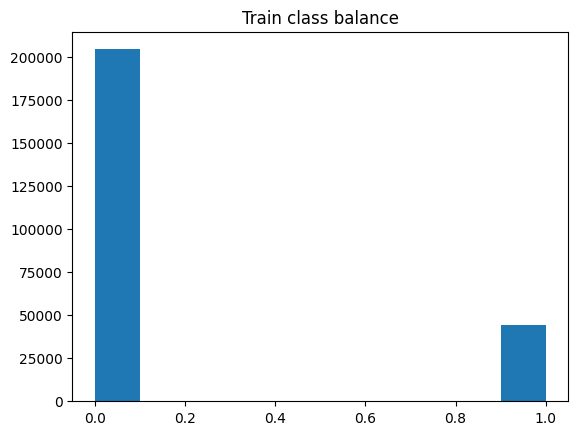

Train active:  44036
Train inactive:  204403
Percentage active:  17.725075370614114 %


In [26]:
# Class balance
plt.hist(y_Sanus_train)
plt.title('Train class balance')
plt.show()

print("Train active: ", int(np.sum(y_Sanus_train)))
print("Train inactive: ", np.sum(y_Sanus_train == 0))
print("Percentage active: ", np.sum(y_Sanus_train)*100 / len(y_Sanus_train), "%")



In [27]:
# Downsample the inactive class
idx = np.where(y_Sanus_train == 0)[0]
idx = np.random.choice(idx, np.sum(y_Sanus_train == 1), replace=False)
idx = np.concatenate([np.where(y_Sanus_train == 1)[0], idx])

X_train_Sanus = X_train[idx]
y_Sanus_train = y_Sanus_train[idx]


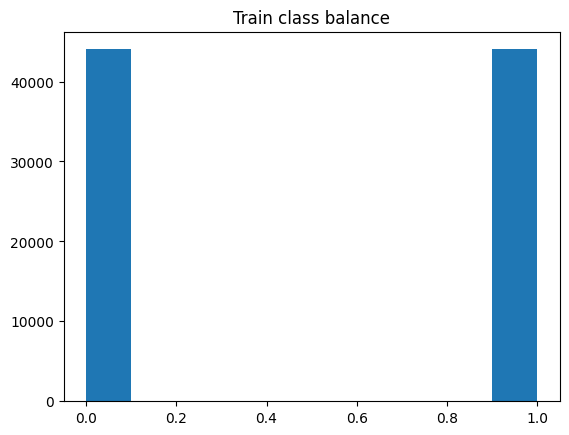

In [28]:
# class balance
plt.hist(y_Sanus_train)
plt.title('Train class balance')
plt.show()


In [29]:
n_train = 5
accs = []
models = []
for i in range(n_train):
    print("Train ", i)
    model = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, verbose=True, random_state=np.random.randint(0, 1000))
    model.fit(X_train_Sanus, y_Sanus_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_Sanus_test, y_pred)
    accs.append(acc)
    models.append(model)
    print("Accuracy: ", acc)

Train  0
Iteration 1, loss = 0.57969133
Iteration 2, loss = 0.48421692
Iteration 3, loss = 0.45755116
Iteration 4, loss = 0.44780486
Iteration 5, loss = 0.43989002
Iteration 6, loss = 0.43571418
Iteration 7, loss = 0.43009672
Iteration 8, loss = 0.42811664
Iteration 9, loss = 0.42484285
Iteration 10, loss = 0.42219335
Iteration 11, loss = 0.41866042
Iteration 12, loss = 0.41658457
Iteration 13, loss = 0.41373934
Iteration 14, loss = 0.41295758
Iteration 15, loss = 0.41039242
Iteration 16, loss = 0.40882426
Iteration 17, loss = 0.40638930
Iteration 18, loss = 0.40533120
Iteration 19, loss = 0.40432093
Iteration 20, loss = 0.40136469
Iteration 21, loss = 0.39901072
Iteration 22, loss = 0.39820654
Iteration 23, loss = 0.39377787
Iteration 24, loss = 0.39526832
Iteration 25, loss = 0.39305155
Iteration 26, loss = 0.39141750
Iteration 27, loss = 0.38827931
Iteration 28, loss = 0.38904204
Iteration 29, loss = 0.38617557
Iteration 30, loss = 0.38346105
Iteration 31, loss = 0.38302257
Iteratio

In [33]:
# accuracy
print("Mean accuracy: ", np.mean(accs))
print("Std accuracy: ", np.std(accs))
print("Accuracy = ", np.mean(accs), " +/- ", np.std(accs))


Mean accuracy:  0.8221413620995008
Std accuracy:  0.009620275671860821
Accuracy =  0.8221413620995008  +/-  0.009620275671860821


In [34]:
# best model
model = models[np.argmax(accs)]
y_pred = model.predict(X_test)
acc = accuracy_score(y_Sanus_test, y_pred)
print("Accuracy: ", acc)


Accuracy:  0.8370793753018837


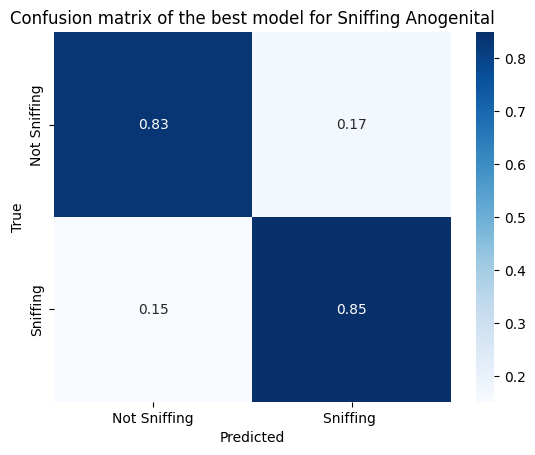

In [35]:
# Confusion matrix
cm = confusion_matrix(y_Sanus_test, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plt.title('Confusion matrix of the best model for Sniffing Anogenital')
sns.heatmap(cm, annot=True, xticklabels=['Not Sniffing', 'Sniffing '], yticklabels=['Not Sniffing', 'Sniffing'], cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [36]:
# Save the model
joblib.dump(model, 'baseline_models/new_dataset/model_Sanus.pkl')

['baseline_models/new_dataset/model_Sanus.pkl']

---

In [ ]:
print(beh_names[5])
print(beh_names.shape)
print(y_train.shape)

### Poursuite Resident

In [68]:
y_poursuitR_train = y_train[:, 5]
y_poursuitR_test = y_test[:, 5]

In [ ]:
# Check Nans in the data

print(np.isnan(y_poursuitR_train).sum())

# Discard the Nans
X_train_pourR = X_train[~np.isnan(y_poursuitR_train)]
y_poursuitR_train = y_poursuitR_train[~np.isnan(y_poursuitR_train)]

X_test_pourR = X_test[~np.isnan(y_poursuitR_test)]
y_poursuitR_test = y_poursuitR_test[~np.isnan(y_poursuitR_test)]




In [ ]:
# Class Balance
plt.hist(y_poursuitR_train)
plt.title('Train class balance')
plt.show()

print('Active: ', y_poursuitR_train.sum())
print('Inactive: ', (1-y_poursuitR_train).sum())
print(' Percentage of active: ', y_poursuitR_train.sum() / len(y_poursuitR_train))

**I don't have yet sufficient data, but let's try it anyway**

In [71]:
# Downsample the inactive class
idx = np.where(y_poursuitR_train == 0)[0]
idx = np.random.choice(idx, np.sum(y_poursuitR_train == 1), replace=False)
idx = np.concatenate([np.where(y_poursuitR_train == 1)[0], idx])

X_train_pourR = X_train[idx]
y_poursuitR_train = y_poursuitR_train[idx]


In [ ]:
# class balance
plt.hist(y_poursuitR_train)
plt.title('Train class balance')
plt.show()

print('Dimension of the training set: ', X_train_pourR.shape)


In [27]:
# Too many features

In [ ]:
# 5 train to see variance
n_train = 5
accs = []
models = []
for i in range(n_train):
    print("Train ", i)
    model = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, verbose=True)
    model.fit(X_train_pourR, y_poursuitR_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_poursuitR_test, y_pred)
    accs.append(acc)
    models.append(model)
    print("Accuracy: ", acc)

In [ ]:
# accuracy
print("accuracy: ", accs)
print(" variance accuracy: ", np.var(accs))

print("The accuracy is:", np.mean(accs), " +/- ", np.std(accs))

# Best model
model = models[np.argmax(accs)]
y_pred = model.predict(X_test)
acc = accuracy_score(y_poursuitR_test, y_pred)
print("Accuracy: ", acc)

# Confusion matrix
cm = confusion_matrix(y_poursuitR_test, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plt.title('Confusion matrix of the best model for Following')
sns.heatmap(cm, annot=True, xticklabels=['Not Following', 'Following'], yticklabels=['Not Following', 'Following'], cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
# Save the model
joblib.dump(model, 'baseline_models/new_dataset/model_poursuitR.pkl')

---

In [ ]:
beh_names[6]

## Dominance Resident

In [83]:
y_domR_train = y_train[:,6]
y_domR_test = y_test[:,6]



In [ ]:
# class balance
plt.hist(y_domR_train)
plt.title('Train class balance')
plt.show()

print('Active: ', y_domR_train.sum())
print('Inactive: ', (1-y_domR_train).sum())
print(' Percentage of active: ', y_domR_train.sum() / len(y_domR_train))



In [86]:
# Downsample the inactive class
idx = np.where(y_domR_train == 0)[0]
idx = np.random.choice(idx, np.sum(y_domR_train == 1), replace=False)
idx = np.concatenate([np.where(y_domR_train == 1)[0], idx])

X_train_domR = X_train[idx]
y_domR_train = y_domR_train[idx]



In [ ]:
# class balance
plt.hist(y_domR_train)
plt.title('Train class balance')
plt.show()


In [ ]:
# 5 train to see variance
n_train = 5
accs = []
models = []
for i in range(n_train):
    print("Train ", i)
    model = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, verbose=True)
    model.fit(X_train_domR, y_domR_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_domR_test, y_pred)
    accs.append(acc)
    models.append(model)
    print("Accuracy: ", acc)

    

In [ ]:
# accuracy
print("accuracy: ", accs)
print(" variance accuracy: ", np.var(accs))

print("The accuracy is:", np.mean(accs), " +/- ", np.std(accs))

# Best model
model = models[np.argmax(accs)]
y_pred = model.predict(X_test)
acc = accuracy_score(y_domR_test, y_pred)
print("Accuracy: ", acc)

# Confusion matrix
cm = confusion_matrix(y_domR_test, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plt.title('Confusion matrix of the best model for Dominance')
sns.heatmap(cm, annot=True, xticklabels=['Not Dominance', 'Dominance'], yticklabels=['Not Dominance', 'Dominance'], cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
# Save the model
joblib.dump(model, 'baseline_models/new_dataset/model_domR.pkl')

---

In [ ]:
beh_names[7]

# Rearing R

In [93]:
y_rearingR_train = y_train[:, 7]
y_rearingR_test = y_test[:, 7]

In [ ]:
# Check Nans in the data
np.isnan(y_rearingR_train).sum()

In [ ]:
# Class Balance
plt.hist(y_rearingR_train)
plt.title('Train class balance')
plt.show()

print('Active: ', np.sum(y_rearingR_train == 1))
print('Inactive: ', np.sum(y_rearingR_train == 0))
print('Percentage: ', np.sum(y_rearingR_train == 1) / len(y_rearingR_train))



In [ ]:
# Downsample the inactive class
idx = np.where(y_rearingR_train == 0)[0]
idx = np.random.choice(idx, np.sum(y_rearingR_train == 1), replace=False)
idx = np.concatenate([np.where(y_rearingR_train == 1)[0], idx])
idx = np.random.permutation(idx)

X_rearingR_train = X_train[idx]
y_rearingR_train = y_rearingR_train[idx]

# class balance
plt.hist(y_rearingR_train)
plt.title('Train class balance')
plt.show()

print(' Train dataset size: ', X_rearingR_train.shape)


In [ ]:
# 5 train to see variance
n_train = 5
accs = []
models = []
for i in range(n_train):
    print("Train ", i)
    model = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, verbose=True)
    model.fit(X_rearingR_train, y_rearingR_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_rearingR_test, y_pred)
    accs.append(acc)
    models.append(model)
    print("Accuracy: ", acc)

In [ ]:
beh_names

In [ ]:
# accuracy
print("accuracy: ", accs)
print(" variance accuracy: ", np.var(accs))

print("The accuracy is:", np.mean(accs), " +/- ", np.std(accs))

# Best model
model = models[np.argmax(accs)]
y_pred = model.predict(X_test)
acc = accuracy_score(y_rearingR_test, y_pred)
print("Accuracy: ", acc)

# Confusion matrix
cm = confusion_matrix(y_rearingR_test, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plt.title('Confusion matrix of the best model for Rearing')
sns.heatmap(cm, annot=True, xticklabels=['No Rearing', 'Rearing'], yticklabels=['No Rearing', 'Rearing'], cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# save the model
joblib.dump(model, 'baseline_models/new_dataset/model_rearingR.pkl')

---

In [ ]:
beh_names[8]

## Grooming Resident

In [ ]:
y_groomR_train = y_train[:, 8]
y_groomR_test = y_test[:, 8]

# Check Nans in the data
print("Nan's ", np.isnan(y_groomR_train).sum())

# Class Balance
plt.hist(y_groomR_train)
plt.title('Train class balance')
plt.show()

print('Active: ', np.sum(y_groomR_train == 1))
print('Inactive: ', np.sum(y_groomR_train == 0))
print('Percentage: ', np.sum(y_groomR_train == 1) / len(y_groomR_train))



In [ ]:
# Downsample the inactive class
idx = np.where(y_groomR_train == 0)[0]
idx = np.random.choice(idx, np.sum(y_groomR_train == 1), replace=False)
idx = np.concatenate([np.where(y_groomR_train == 1)[0], idx])
idx = np.random.permutation(idx)

X_groomR_train = X_train[idx]
y_groomR_train = y_groomR_train[idx]

# class balance
plt.hist(y_groomR_train)
plt.title('Train class balance')
plt.show()

print(' Train dataset size: ', X_groomR_train.shape)


In [ ]:
# 5 train to see variance
n_train = 5
accs = []
models = []
for i in range(n_train):
    print("Train ", i)
    model = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, verbose=True)
    model.fit(X_groomR_train, y_groomR_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_groomR_test, y_pred)
    accs.append(acc)
    models.append(model)
    print("Accuracy: ", acc)

In [ ]:
# accuracy
print("accuracy: ", accs)
print(" variance accuracy: ", np.var(accs))

print("The accuracy is:", np.mean(accs), " +/- ", np.std(accs))

# Best model
model = models[np.argmax(accs)]
y_pred = model.predict(X_test)
acc = accuracy_score(y_groomR_test, y_pred)
print("Accuracy: ", acc)

# Confusion matrix
cm = confusion_matrix(y_groomR_test, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plt.title('Confusion matrix of the best model for Grooming')
sns.heatmap(cm, annot=True, xticklabels=['No Grooming', 'Grooming'], yticklabels=['No Grooming', 'Grooming'], cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

THis makes no sense

In [ ]:
# save the model
joblib.dump(model, 'baseline_models/new_dataset/model_groomR.pkl')


In [ ]:
# run several times to get the variance of the accuracy
acc = []

for i in range(10):
    y_groomR_train = y_train[:, 6]
    y_groomR_test = y_test[:, 6]

    # Downsample the inactive class
    idx = np.where(y_groomR_train == 0)[0]
    idx = np.random.choice(idx, np.sum(y_groomR_train == 1), replace=False)
    idx = np.concatenate([np.where(y_groomR_train == 1)[0], idx])
    idx = np.random.permutation(idx)

    X_groomR_train = X_train[idx]
    y_groomR_train = y_groomR_train[idx]

    model = MLPClassifier(hidden_layer_sizes=(100), max_iter=1000, verbose=False, random_state=42) 

    # Train the model
    model.fit(X_groomR_train, y_groomR_train)

    # Test the model
    y_pred = model.predict(X_test)

    acc.append(accuracy_score(y_groomR_test, y_pred))

print('Mean accuracy: ', np.mean(acc))
print('Variance: ', np.var(acc))

---

In [ ]:
beh_names[7]

## Sinff Visiteur

In [383]:
y_sniffV_train = y_train[:, 7]
y_sniffV_test = y_test[:, 7]


In [ ]:
# Class Balance
plt.hist(y_sniffV_train)
plt.title('Train class balance')
plt.show()

print('Active: ', np.sum(y_sniffV_train == 1))
print('Inactive: ', np.sum(y_sniffV_train == 0))
print('Percentage: ', np.sum(y_sniffV_train == 1) / len(y_sniffV_train))



In [385]:
# Downsample the Inactive class
np.random.seed(42)
idx = np.where(y_sniffV_train == 0)[0]
idx = np.random.choice(idx, np.sum(y_sniffV_train == 1), replace=False)
idx = np.concatenate([idx, np.where(y_sniffV_train == 1)[0]])
idx = np.random.permutation(idx)
X_train_sniff_V = X_train[idx]
y_sniffV_train = y_sniffV_train[idx]

In [ ]:
# class balance
plt.hist(y_sniffV_train)
plt.title('Train class balance')
plt.show()

print(' Train dataset size: ', X_train_sniff_V.shape)


In [387]:
# Create the model
model = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, verbose=True)


In [ ]:
# Train the model
model.fit(X_train_sniff_V, y_sniffV_train)


In [ ]:
y_pred = model.predict(X_test)

accuracy_score(y_sniffV_test, y_pred)

In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(y_sniffV_test, y_pred)
conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_matrix, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
# Save the model
joblib.dump(model, 'baseline_models/model_sniffV.pkl')

---

In [ ]:
beh_names[8]

## Poursuite Visiteur

In [393]:
y_poursuitV_train = y_train[:, 8]
y_poursuitV_test = y_test[:, 8]


In [ ]:
# check Nans in the data
print(np.isnan(y_poursuitV_train).sum())

# Class Balance
plt.hist(y_poursuitV_train)
plt.title('Train class balance')
plt.show()

print('Active: ', np.sum(y_poursuitV_train == 1))
print('Inactive: ', np.sum(y_poursuitV_train == 0))
print('Percentage: ', np.sum(y_poursuitV_train == 1) / len(y_poursuitV_train))



---

In [ ]:
beh_names[9]

## Dominance Visiteur

In [ ]:
y_domV_train = y_train[:, 9]
y_domV_test = y_test[:, 9]

# Check Nans in the data
print(np.isnan(y_domV_train).sum())

# Class Balance
plt.hist(y_domV_train)
plt.title('Train class balance')
plt.show()

print('Active: ', np.sum(y_domV_train == 1))
print('Inactive: ', np.sum(y_domV_train == 0))
print('Percentage: ', np.sum(y_domV_train == 1) / len(y_domV_train))


In [ ]:
# Downsample the Inactive class
np.random.seed(42)
idx = np.where(y_domV_train == 0)[0]
idx = np.random.choice(idx, np.sum(y_domV_train == 1), replace=False)
idx = np.concatenate([idx, np.where(y_domV_train == 1)[0]])
idx = np.random.permutation(idx)

X_train_dom_V = X_train[idx]
y_domV_train = y_domV_train[idx]

# class balance
plt.hist(y_domV_train)
plt.title('Train class balance')
plt.show()

print(' Train dataset size: ', X_train_dom_V.shape)


In [ ]:
# Create the model
model = MLPClassifier(hidden_layer_sizes=(100), max_iter=1000, verbose=True)

# Train the model
model.fit(X_train_dom_V, y_domV_train)



In [ ]:
# Test the model
y_pred = model.predict(X_test)

accuracy_score(y_domV_test, y_pred)

In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(y_domV_test, y_pred)
conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_matrix, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


---

In [ ]:
beh_names[10]

---

In [ ]:
beh_names[11]

## Grooming Visiteur

In [150]:
y_groomV_train = y_train[:, 11]
y_groomV_test = y_test[:, 11]

In [ ]:
print(len(y_groomV_train))

In [ ]:
# Class Balance
plt.hist(y_groomV_train)
plt.title('Train class balance')
plt.show()

print('Active: ', np.sum(y_groomV_train == 1))
print('Inactive: ', np.sum(y_groomV_train == 0))
print('Percentage: ', np.sum(y_groomV_train == 1) / len(y_groomV_train))


In [ ]:
# Downsample the Inactive class
np.random.seed(42)
idx = np.where(y_groomV_train == 0)[0]
idx = np.random.choice(idx, np.sum(y_groomV_train == 1), replace=False)
idx = np.concatenate([idx, np.where(y_groomV_train == 1)[0]])
idx = np.random.permutation(idx)
X_train_groom_V = X_train[idx]
y_groomV_train = y_groomV_train[idx]

# class balance
plt.hist(y_groomV_train)
plt.title('Train class balance')
plt.show()

print(X_train_groom_V.shape)

In [154]:
# Create the model
model = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, verbose=True, tol = 1e-5)


In [ ]:
# Train the model
model.fit(X_train_groom_V, y_groomV_train)

In [ ]:
y_pred = model.predict(X_test)
accuracy_score(y_groomV_test, y_pred)

In [ ]:
print(' Predicted: ', y_pred.sum())
print(' Non predicted: ', len(y_pred) - y_pred.sum())

In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(y_groomV_test, y_pred)
conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_matrix, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


---

In [ ]:
beh_names[12]

In [ ]:
y_pourV_train = y_train[:, 7]
y_pourV_test = y_test[:, 10]

# Class Balance
plt.hist(y_pourV_train)
plt.title('Train class balance')
plt.show()


---

---

---

---


---

---

---

---

---

---

---

---

---

# This is only data cleannning, renaming, grouping, etc

#### Extra checks

In [42]:
import os

In [44]:
df = pd.read_csv(r'c:\Users\jalvarez\Documents\Data\DataLoader_DMD_null_male\DMD_mal_Test_1.csv')
original_column = df.columns

In [45]:
# Check that the columns are ordered in the .csv files contained in the path
files_path = r'c:\Users\jalvarez\Documents\Data\DataLoader_DMD_null_male' 

for file in os.listdir(files_path):
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(files_path, file))
        if not np.array_equal(original_column, df.columns):
            print(file)
        

### Adding all the missing behaviors

In [ ]:
csv_file = r'c:\Users\jalvarez\Documents\Data\Behaviour\MDX5CV\male female\Test_1.csv'

df = pd.read_csv(csv_file)
df.sum(axis=0)

In [47]:
behaviours = ['Frames', 'General_Contacts', 'Sniffing_R', 'Poursuit_R', 'Dominance_R', 'Rearing_R', 'Grooming_R', 'Sniffing_V', 'Poursuit_V', 'Dominance_V', 'Rearing_V', 'Grooming_V']
original_column = ['Frame', 'contacts generaux (R + V) active', 'sniff total resident active', 'poursuite R active', 'dominance R active', 'redressement R active', 'grooming R active',
                    'sniff total visiteur active', 'poursuite V active', 'dominance V active', 'redressement V active', 'grooming V active']

In [48]:
dict_columns = dict(zip(original_column, behaviours))

In [ ]:
dict_columns

In [ ]:
for i in range(len(behaviours)):
    print(behaviours[i], '--', original_column[i])

In [ ]:
# Reorder and rename the columns
df = pd.read_csv(csv_file)
df.sum(axis=0)


In [ ]:
df = df[original_column]
df.sum(axis=0)


In [41]:
df.columns = behaviours

In [ ]:
df.sum(axis=0)

In [30]:
import os

In [44]:
# Edit the csv files in the path
path = r'c:\Users\jalvarez\Documents\Data\Behaviour\MDX5CV\male female - Copie'
for file in os.listdir(path):
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(path, file))
        df = df[original_column]
        df.columns = behaviours
        df.to_csv(os.path.join(path, file), index=False)
        
        

**Now DMD null**

In [ ]:
file = r'c:\Users\jalvarez\Documents\Data\Behaviour\DMD\male female\Test_1.csv'
df = pd.read_csv(file)
df.sum(axis=0)

In [74]:
behaviours = ['Frames', 'General_Contacts', 'Sniffing_R', 'Poursuit_R', 'Dominance_R', 'Rearing_R', 'Grooming_R', 'Sniffing_V', 'Poursuit_V', 'Dominance_V', 'Rearing_V', 'Grooming_V']
original_column = ['Frame', 'contacts generaux (R + V) active', 'sniff total R active', 'Poursuit R active', 'dominance R active', 'Redressement R active', 'Grooming R active',
                    'sniff total V active', 'Poursuit V active', 'Dominance V active', 'Redressement Q active', 'Grooming V active']

dict_columns = dict(zip(original_column, behaviours))

In [ ]:
dict_columns.keys()

In [ ]:
actual_columns = list(df.columns)
actual_columns

In [ ]:
for beh in dict_columns.keys():
    if beh not in actual_columns:
        print(beh)

In [78]:
folder = r'c:\Users\jalvarez\Documents\Data\Behaviour\DMD\male female - Copie'

for file in os.listdir(folder):
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(folder, file))
        for beh in dict_columns.keys():
            if beh not in df.columns:
                # Add the column in that position, filled with NaNs
                df[dict_columns[beh]] = np.nan
            else:
                df = df.rename(columns={beh: dict_columns[beh]})
        df = df[behaviours]
        df.to_csv(os.path.join(folder, file), index=False)
        

In [ ]:
file = r'c:\Users\jalvarez\Documents\Data\Behaviour\DMD\male female - Copie\Test_1.csv'
df = pd.read_csv(file)
df.sum(axis=0)
df.isna().sum(axis=0)

### Rename

In [83]:
# add a name before each file

folder = r'c:\Users\jalvarez\Documents\Data\Behaviour\MDX5CV\male female - Copie'

for file in os.listdir(folder):
    if file.endswith(".csv"):
        new_name = 'MDXCV_fem_' + file
        os.rename(os.path.join(folder, file), os.path.join(folder, new_name))

In [ ]:
importlib.reload(DataDLC)

In [268]:
data_dlc = DataDLC.DataDLC(r'c:\Users\jalvarez\Documents\Data\DataLoader_Baseline_models\DMD_mal_Test_21DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5')

In [ ]:
video_path = r'c:\Users\jalvarez\Documents\Data\DLC_analyzedvid\DMD_null\DMD_null_male\DMD_mal_Test 21DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered_id_labeled.mp4'
output_path = r'c:\Users\jalvarez\Documents\Data\OL\Nouveau dossier'
behaviour_path = r'c:\Users\jalvarez\Documents\Data\DataLoader_Baseline_models\DMD_mal_Test_21.csv'

events = pd.read_csv(behaviour_path) # Load the events
data_dlc.create_video_per_event(video_path, output_path, events, split_behaviour=True)





## Grooming trainning dataset

In [ ]:
# For each video in the dataset, see which has more grooming events
import os

groomingR = []
for data_point in dataset:
    beh = data_point[1]
    groomingR.append(beh['Grooming_R'].sum()) 

print('The video with more grooming events is: ', data_loader.files[40])

In [ ]:
len(dataset)

In [ ]:
video = r'c:\Users\jalvarez\Documents\Data\videos\+2mice\OBS Studio\2024-08-29 11-37-00.mkv'

# See frame rate
cap = cv2.VideoCapture(video)
fps = cap.get(cv2.CAP_PROP_FPS)
cap.release()

print('Frame rate: ', fps)

# Close everything
cv2.destroyAllWindows()
cv2.waitKey(1)